<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  


</br>  
</br>  
*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [4]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [5]:
store1 = data[data['Store']==1] 

In [6]:
store1.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [7]:
Weekly_Sales = pd.DataFrame(store1['Weekly_Sales'].groupby(store1.index).sum())

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

Text(0.5, 1.0, 'Weekly Sales for Store One -- ROLLBACKS Everyday!!!')

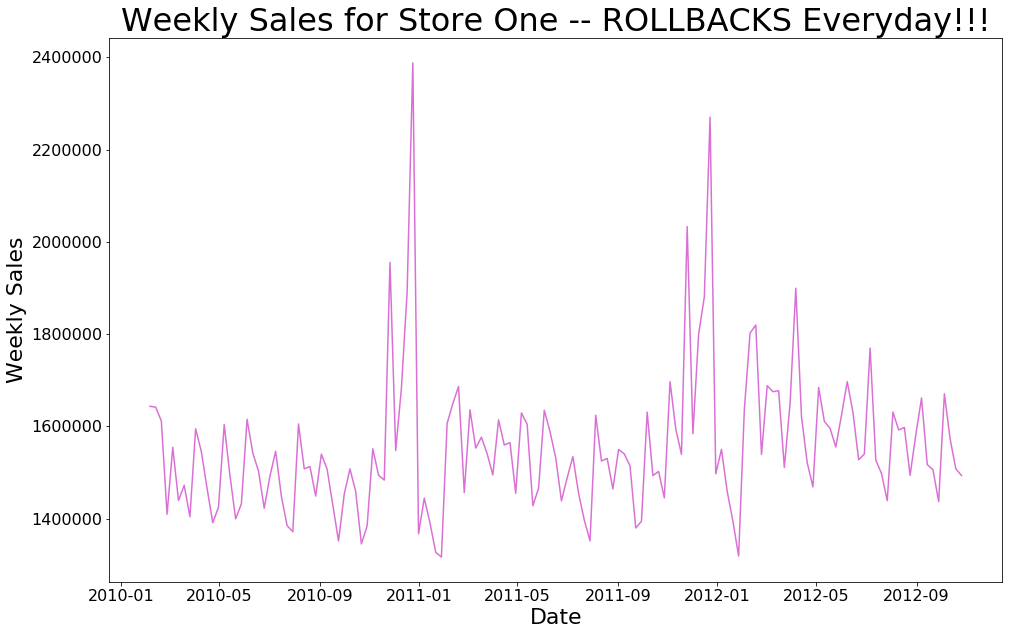

In [8]:
plt.figure(figsize=(16,10))
plt.plot(Weekly_Sales, c='orchid')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('Date', fontsize=22)
plt.ylabel('Weekly Sales', fontsize=22)
plt.title('Weekly Sales for Store One -- ROLLBACKS Everyday!!!', fontsize=32)

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

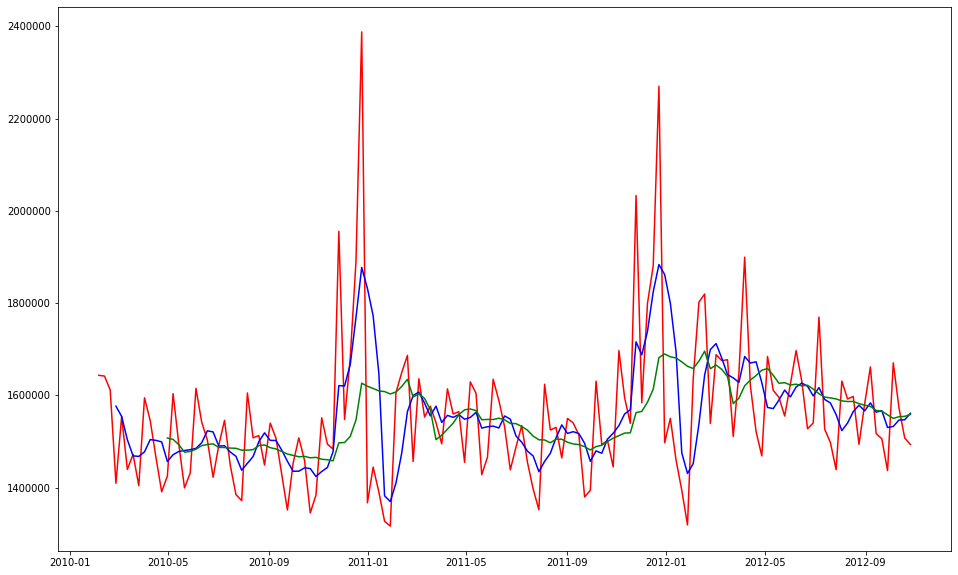

In [9]:
#Set a rolling mean with windows of 1, 4, and 13
rollmean1 = Weekly_Sales.rolling(window = 1).mean()
rollmean4 = Weekly_Sales.rolling(window = 4).mean()
rollmean13 = Weekly_Sales.rolling(window = 13).mean()

#Plot
plt.figure(figsize=(16,10))
plt.plot(rollmean1, color = 'red', label = '1 Week Rolling Mean')
plt.plot(rollmean4, color = 'blue', label = '4 Week Rolling Mean')
plt.plot(rollmean13, color = 'green', label = '13 Week Rolling Mean')

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* There is a trend where it appears to be a long-term increase over time.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [10]:
[Weekly_Sales["Weekly_Sales"].autocorr(i) for i in [1,2,4,13,52]]

[0.3021582794113126,
 0.12741313055390097,
 0.2381929408831175,
 0.10169228501987719,
 0.8953760294777008]

In [11]:
for shift_amount in [1, 2, 53]:
    Weekly_Sales['shift'] = Weekly_Sales.shift(shift_amount)
    print(shift_amount,'week lag | r=', round(Weekly_Sales.corr()['shift'][0],3))

1 week lag | r= 0.302
2 week lag | r= 0.127
53 week lag | r= 0.294


**3b. What can you say about the series based on these autocorrelations?**

Answer: The series are not stationary based on these autocorrelations.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

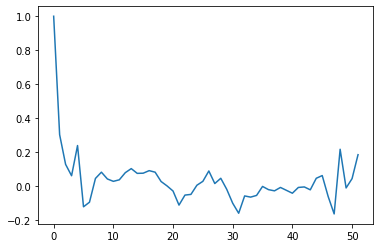

In [12]:
corrs = []
for i in range(52):
    Weekly_Sales['shift'] = Weekly_Sales.shift(i)
    corrs.append(round(Weekly_Sales.corr()['shift'][0],3))
plt.plot(corrs);

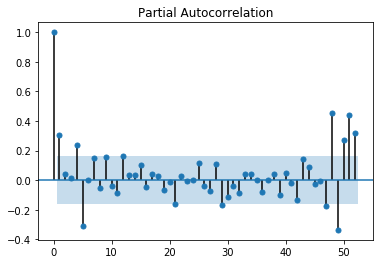

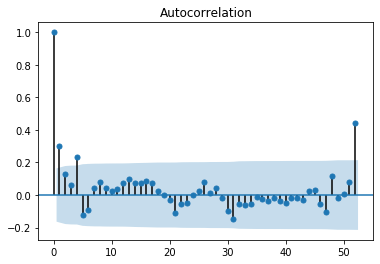

In [13]:
# 52-Week Autocorr Plot and Partial Autocorr
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 52);

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Weekly_Sales['Weekly_Sales'], lags=52);


#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:
* The ACF graph tells me there's a trend at lag =0, 1, and 52. There doesn't seem to be seasonality detected here aside from lag = 9 to 13.
* The PACF graph shows seasonality at lag =48, 50, 51, and 52.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: Seeing how there's a trend based on the ACF plot, we can also us the lage = 1, 48, 50, 51, 52 from the PACF plot as a predictor for our model selections.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [14]:
len(Weekly_Sales)

143

In [15]:
round(len(Weekly_Sales) * .75)

107

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Weekly_Sales['Weekly_Sales'],
                               test_size = 0.25,
                              shuffle=False)

In [17]:
train = Weekly_Sales['Weekly_Sales'].iloc[:108,]

test = Weekly_Sales['Weekly_Sales'].iloc[108:,]

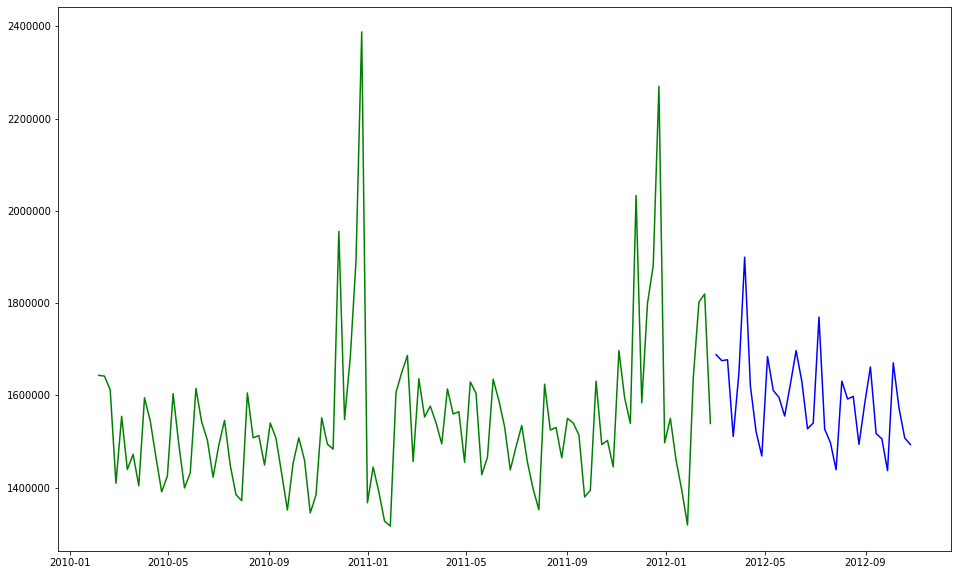

In [18]:
plt.figure(figsize = (16,10))
plt.plot(train, c = 'green')
plt.plot(test, c = 'blue')

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [19]:
#Split training data to train values and dates
train_values = train.values
train_dates = train.index

#Fit model on training data
model = AR(train_values, train_dates).fit()

#Split test data into what we know
test_values = test.values
test_dates = test.index

#Create a start and end dates for prediction
start = test.index[0]
end = test.index[-1]

#Generate prediction on starting
model_pred = model.predict(start, end)

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [20]:
mean_absolute_error(test, model_pred)

73821.74423725788

**6c. How effective do you think this `AR(1)` model is?**

Answer: AR(1) is off about 73,821 a week in sales, which seems to be less than 10 percent error so it may be an effective model.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [21]:
AR1_residuals = test_values - model_pred

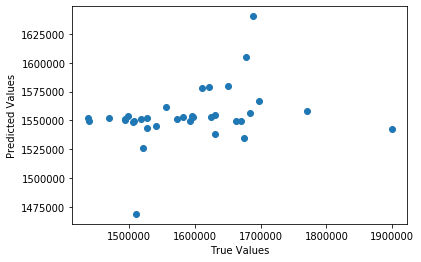

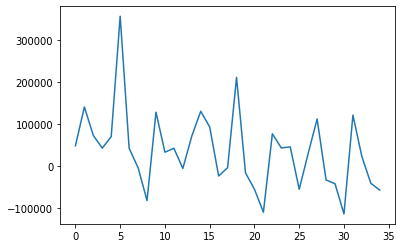

In [22]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, model_pred)
plt.show()

plt.plot(AR1_residuals)
plt.show()

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: The major peaks at days 5 and 18 have the most significant errors.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [23]:
AR2 = ARMA(endog = train_values,
           dates = train_dates,
           order = (2,0)).fit()

AR2_pred = AR2.predict(start = start,
                       end = end)

mean_absolute_error(test_values, AR2_pred)

82145.14166598508

In [24]:
AR2_2 = ARMA(endog = train_values,
            dates = train_dates,
            order = (2,2)).fit()

AR2_2_pred = AR2_2.predict(start = start, end = end)

mean_absolute_error(test_values, AR2_2_pred)

82166.92332406675

**8b. How did your results change?**

Answer: The MAE indicate worse results from the original AR model. However, the MAE of ARMA(2,2) is slightly better than the ARMA(2.0)

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

Fit ARMA (2,2) in 8a

In [25]:
AR2_residuals = test_values - AR2_pred

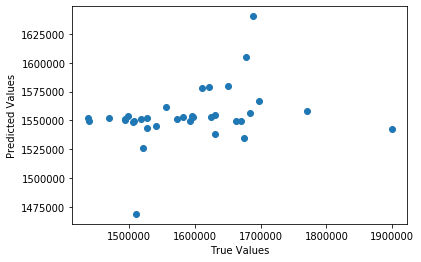

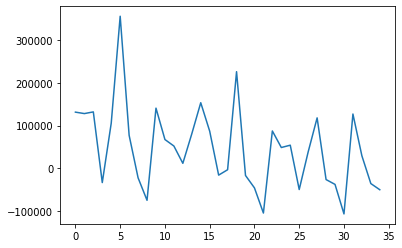

In [26]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, model_pred)
plt.show()

plt.plot(AR2_residuals)
plt.show()

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: answered in 8b

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [27]:
adfuller(data['Weekly_Sales'])

(-31.988781724011947,
 0.0,
 97,
 421472,
 {'1%': -3.4303655154786736,
  '5%': -2.861546857656134,
  '10%': -2.5667736500803486},
 8545552.175247807)

In [28]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [29]:
interpret_dftest(adfuller(data['Weekly_Sales']))

Test Statistic   -31.988782
p-value            0.000000
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: Because p = 0, it is smaller than $a$. Thus we can accept that our series Weekly_Sales is stationary.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [30]:
data['ws_diff1'] = data['Weekly_Sales'].diff(1)
data['ws_diff2'] = data['Weekly_Sales'].diff(2)
data['ws_diff3'] = data['Weekly_Sales'].diff(3)
data['ws_diff4'] = data['Weekly_Sales'].diff(4)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday,ws_diff1,ws_diff2,ws_diff3,ws_diff4
Date,,,,,,,,
2010-02-05,1,1,24924.50,False,NaN,NaN,NaN,NaN
2010-02-12,1,1,46039.49,True,21114.99,NaN,NaN,NaN
2010-02-19,1,1,41595.55,False,-4443.94,16671.05,NaN,NaN
2010-02-26,1,1,19403.54,False,-22192.01,-26635.95,-5520.96,NaN
2010-03-05,1,1,21827.90,False,2424.36,-19767.65,-24211.59,-3096.6


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [31]:
interpret_dftest(adfuller(data['ws_diff1'].dropna()))

Test Statistic   -69.840943
p-value            0.000000
dtype: float64

In [32]:
interpret_dftest(adfuller(data['ws_diff2'].dropna()))

Test Statistic   -65.146819
p-value            0.000000
dtype: float64

In [33]:
interpret_dftest(adfuller(data['ws_diff3'].dropna()))

Test Statistic   -66.697515
p-value            0.000000
dtype: float64

In [34]:
interpret_dftest(adfuller(data['ws_diff4'].dropna()))

Test Statistic   -66.479732
p-value            0.000000
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: Since all the models ahve a p value of 0, it wouldn't matter where the data differenced would be.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: Using the ARIMA model wouldn't make sense since the model is already stationary thus randering ARIMA unnecessary because ARIMA converts data to stationary.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [39]:
# Instantiate best model.
model = ARIMA(endog = train.astype(float).dropna(),
              order = (2, 1, 2))
# Fit ARIMA model.
arima = model.fit()
# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = start, 
                      end = end)
mean_absolute_error(test_values, preds)

1587196.844742831

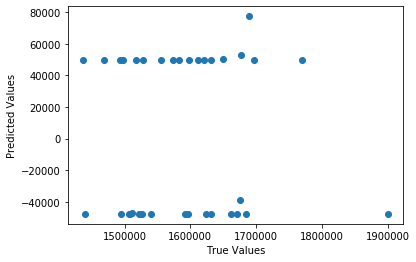

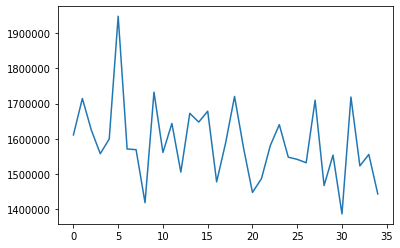

In [40]:
ARIMA_residuals = test_values - preds
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, preds)
plt.show()

plt.plot(ARIMA_residuals)
plt.show()

**11b. Interpret the results from the last answer.**


Answer: The major peaks at 5, 9, 18, 27, and 31 have the most signicant errors.

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [64]:
sari_model= SARIMAX(endog = train.astype(float).dropna(),
                    seasonal_order= (1, 1, 1, 1),
                    order=(2,0,2)
                   )

In [66]:
sari = sari_model.fit()

predictions= sari.predict()

mean_absolute_error(train_values,predictions)

130480.0717306996

**12b. How did your best SARIMAX model perform?**

Answer: The SARIMAX model has an error more than double than that of the AR and ARMA models. Thus, SARIMAX model performed poorly.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

In [67]:
AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(2, 0)   Log Likelihood               -1447.580
Method:                       css-mle   S.D. of innovations         160187.364
Date:                Sun, 23 Feb 2020   AIC                           2903.160
Time:                        22:35:07   BIC                           2913.889
Sample:                    02-05-2010   HQIC                          2907.510
                         - 02-24-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.33e+04     66.170      0.000     1.5e+06    1.59e+06
ar.L1.y        0.2903      0.096      3.031      0.003       0.103       0.478
ar.L2.y        0.0525      0.097      0.542      0.589      -0.137       0.242
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4020           +0.0000j            2.4020            0.0000
AR.2           -7.9370           +0.0000j            7.9370            0.5000
-----------------------------------------------------------------------------
"""

In [68]:
AR2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(2, 2)   Log Likelihood               -1438.590
Method:                       css-mle   S.D. of innovations         143453.854
Date:                Sun, 23 Feb 2020   AIC                           2889.180
Time:                        22:35:24   BIC                           2905.272
Sample:                    02-05-2010   HQIC                          2895.705
                         - 02-24-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06    1.9e+04     81.070      0.000    1.51e+06    1.58e+06
ar.L1.y       -1.0397      0.089    -11.636      0.000      -1.215      -0.865
ar.L2.y       -0.4700      0.087     -5.404      0.000      -0.640      -0.300
ma.L1.y        1.4689      0.056     26.283      0.000       1.359       1.578
ma.L2.y        0.9997      0.071     14.092      0.000       0.861       1.139
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9510j            1.4586           -0.3870
AR.2           -1.1060           +0.9510j            1.4586            0.3870
MA.1           -0.7346           -0.6786j            1.0001           -0.3813
MA.2           -0.7346           +0.6786j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

The ARMA 1 model performed the best because the data has become stationary.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer:  The model seem to overfit a lot making it bad at predicting weekly sales moving forward.

**13c. How might you improve it?**

Answer: Possibly some feature engineering and stnadard scaling is in order to improve the model.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: